In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

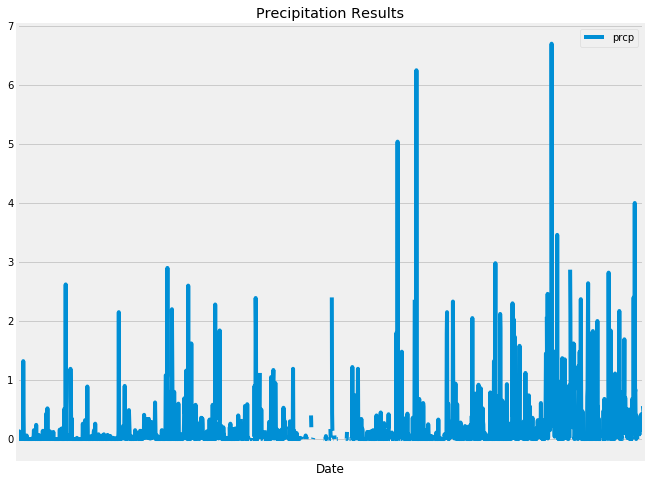

In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Perform a query to retrieve the data and precipitation scores
qdate=dt.date(2017,8,23)-dt.timedelta(days=365)
re=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=qdate).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df=pd.DataFrame(re)
df.set_index('date')
# Sort the dataframe by date
df = df.sort_index()
df.plot(title='Precipitation Results',figsize=(10,8))
# Use Pandas Plotting with Matplotlib to plot the data
plt.xticks([])
plt.xlabel('Date')
plt.show()

In [29]:
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [34]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [37]:
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [44]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()


[(54.0, 85.0, 71.66378066378067)]

In [48]:
session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()


('USC00519281', 2772)

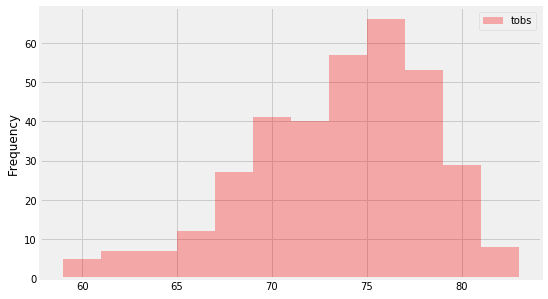

In [64]:
qdate=dt.date(2017,8,23)-dt.timedelta(days=365)
temps=session.query(Measurement.tobs).filter(Measurement.date>=qdate).filter(Measurement.station=='USC00519281').all()
df_temp=pd.DataFrame(temps,columns=['tobs'])
df_temp.plot.hist(bins=12, facecolor='red', alpha=0.3, figsize=(8,5))

In [65]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [67]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps('2017-02-28', '2017-03-05')

[(64.0, 72.02777777777777, 78.0)]

Text(0, 0.5, 'Temp(F)')

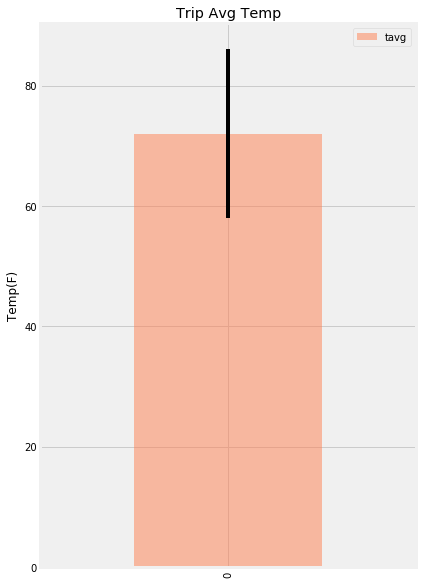

In [76]:
toplot=calc_temps('2017-02-28', '2017-03-05')
df_p=pd.DataFrame(toplot,columns=['tmin','tavg','tmax'])
df_p.plot.bar(y='tavg',yerr=df_p['tmax']-df_p['tmin'],color='coral',alpha=0.5,title='Trip Avg Temp',figsize=(6,10))
plt.ylabel('Temp(F)')

In [87]:
calc_temps('2017-02-28', '2017-03-05')
sdate=dt.date(2012,2,28)
edate=dt.date(2012,3,6)
session.query(Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)).\
filter(Measurement.station==Station.station).filter(Measurement.date>=sdate).filter(Measurement.date<=edate).\
group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  13.67),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  12.93),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  9.3),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  8.120000000000001),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 5.18),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  3.8400000000000003),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  3.59),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.91),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]

## Optional Challenge Assignment

In [82]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [152]:
sdate=dt.date(2017,2,28)
edate=dt.date(2017,3,6)
delta=edate-sdate
dates=[]
for i in range(delta.days+1):
    day=sdate+timedelta(days=i)
    dates.append(day)
dates

[datetime.date(2017, 2, 28),
 datetime.date(2017, 3, 1),
 datetime.date(2017, 3, 2),
 datetime.date(2017, 3, 3),
 datetime.date(2017, 3, 4),
 datetime.date(2017, 3, 5),
 datetime.date(2017, 3, 6)]

In [138]:
lis=[dt.date(2017,2,28).strftime("%m-%d"),dt.date(2017,3,1).strftime("%m-%d"),dt.date(2017,3,2).strftime("%m-%d"),
     dt.date(2017,3,3).strftime("%m-%d"),dt.date(2017,3,4).strftime("%m-%d"),dt.date(2017,3,5).strftime("%m-%d"),
    dt.date(2017,3,6).strftime("%m-%d")]

['02-28', '03-01', '03-02', '03-03', '03-04', '03-05', '03-06']

In [143]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
temp_s=[]
for a in lis:
    temp_s.append(daily_normals(a))
    print(daily_normals(a))

[(65.0, 70.65517241379311, 80.0)]
[(64.0, 70.0327868852459, 76.0)]
[(61.0, 70.36666666666666, 78.0)]
[(60.0, 70.06896551724138, 78.0)]
[(57.0, 69.27272727272727, 77.0)]
[(60.0, 67.89090909090909, 76.0)]
[(60.0, 69.20338983050847, 76.0)]


In [172]:
df1=pd.DataFrame(temp_s,columns=['tup'])
df1['tmin']=df1['tup'].str[0]
df1['tavg']=df1['tup'].str[1]
df1['tmax']=df1['tup'].str[2]
df1['date']=dates
df1=df1[['tmin','tavg','tmax','date']]
df1['date']= pd.to_datetime(df1['date'])
df1.set_index('date',inplace=True)

In [183]:
df1

,tmin,tavg,tmax
date,,,
2017-02-28,65.0,70.655172,80.0
2017-03-01,64.0,70.032787,76.0
2017-03-02,61.0,70.366667,78.0
2017-03-03,60.0,70.068966,78.0
2017-03-04,57.0,69.272727,77.0
2017-03-05,60.0,67.890909,76.0
2017-03-06,60.0,69.203390,76.0


In [173]:
df1.dtypes

tmin    float64
tavg    float64
tmax    float64
dtype: object

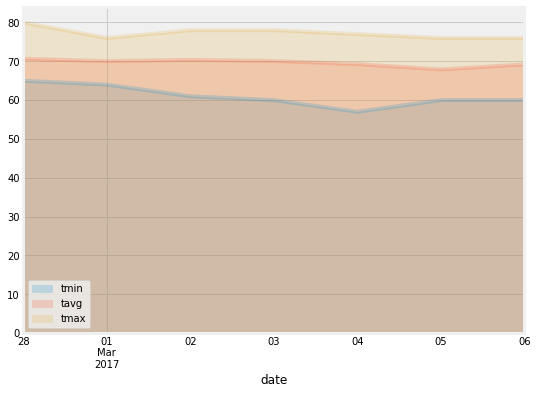

In [184]:
df1.plot.area(stacked=False,figsize=(8,6),alpha=0.2)

<IPython.core.display.Javascript object>


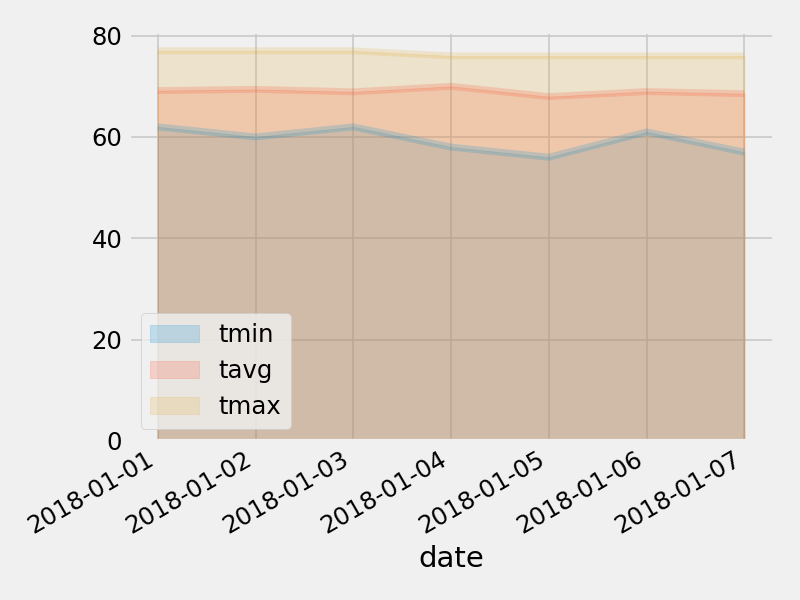

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
